In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
def get_delays_and_profits(paths):
    output = None
    for path in paths:
        master_profit = None
        delays = {}
        for file in os.listdir(path):
            if 'HerdMasterAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    master_profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                except (IndexError, KeyError):
                    continue                
            if 'HerdSlaveAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    delay = df.loc[df.EventType == 'DELAY', 'Event'].values[0]
                    profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    delays[delay] = profit
                except (IndexError, KeyError):
                    continue
        x, y = np.asarray(sorted(delays.items()))[:, 0], np.asarray(sorted(delays.items()))[:, 1]
        temp = pd.DataFrame({'DELAY': x, 'SLAVE_PROFIT': y})
        temp['MASTER_PROFIT'] = master_profit
        temp['SIMULATION'] = path
        if output is None:
            output = temp
        else:
            output = output.append(temp)
    output['PERCENT'] = output.SLAVE_PROFIT/output.MASTER_PROFIT
    output = output.sort_values(by='DELAY').reset_index(drop=True)
    return output

In [53]:
# end-time 12:00:00
# master-window 1e+9
# slave-min-delay 1e+1 
# slave-max-delay 1e+8
# 1 master
# 40 slaves
# limit orders

# Master Strategy
#    if ask < r_f:
#        buy = True
#        p = ask - adjust_int
#        if p >= r_f:
#            return
#    elif bid > r_f:
#        buy = False
#        p = bid + adjust_int
#        size = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else self.size
#        if p <= r_f:
#            return


PATHS = ["log/herd01_2_5_hour_0/", "log/herd01_2_5_hour_1/", "log/herd01_2_5_hour_2/", "log/herd01_2_5_hour_3/",
         "log/herd01_2_5_hour_4/", "log/herd01_2_5_hour_5/"]

df = get_delays_and_profits(PATHS)

In [66]:
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT,g
0,388394.0,199319.0,365427,log/herd01_2_5_hour_1/,0.545441,0
1,513294.0,34572.0,329913,log/herd01_2_5_hour_4/,0.104791,0
2,647346.0,87555.0,336637,log/herd01_2_5_hour_0/,0.260087,0
3,1046636.0,56100.0,329913,log/herd01_2_5_hour_4/,0.170045,0
4,2081557.0,104077.0,329913,log/herd01_2_5_hour_4/,0.315468,0
...,...,...,...,...,...,...
235,97775516.0,42040.0,336637,log/herd01_2_5_hour_0/,0.124882,15
236,97999578.0,111856.0,365427,log/herd01_2_5_hour_1/,0.306097,15
237,98847482.0,11855.0,336637,log/herd01_2_5_hour_0/,0.035216,15
238,98913519.0,25229.0,446145,log/herd01_2_5_hour_5/,0.056549,15


In [70]:
df['g'] = df.index//15
temp = df.groupby('g').agg(['mean', 'std'])

In [71]:
temp

DELAY                 SLAVE_PROFIT                MASTER_PROFIT  \
            mean           std           mean           std           mean   
g                                                                            
0   2.608220e+06  1.452168e+06  114068.666667  53186.895156  361410.600000   
1   8.293857e+06  2.096518e+06  128864.466667  62848.741198  362166.533333   
2   1.563777e+07  3.071628e+06   86404.266667  57396.062603  357570.000000   
3   2.459322e+07  2.525599e+06   75903.533333  87016.292188  387339.800000   
4   3.115303e+07  1.949453e+06   39722.666667  61741.305271  360132.666667   
5   3.644847e+07  1.470394e+06   39675.000000  36782.596921  377422.733333   
6   4.141774e+07  1.979334e+06   45565.666667  28743.053794  384717.066667   
7   4.866323e+07  1.736860e+06   35588.733333  40420.770671  363846.400000   
8   5.256069e+07  1.817819e+06   40339.400000  36276.713534  372485.533333   
9   5.973105e+07  1.763176e+06   42453.466667  36973.334289  357381.733333   
10  6.473141e+07  2.035082e+06   31759.266667  24840.860175  376974.466667   
11  7.243065e+07  2.292215e+06   38027.133333  35173.075199  370251.733333   
12  7.782587e+07  1.334160e+06   26180.533333  29108.877431  374157.266667   
13  8.265718e+07  1.681080e+06   19069.266667  21713.739302  387988.733333   
14  8.895340e+07  1.852931e+06   23132.866667  19734.489721  370947.600000   
15  9.556453e+07  2.704518e+06   25457.266667  29705.760727  361724.466667   

                   PERCENT            
             std      mean       std  
g                                     
0   38756.542330  0.313619  0.141485  
1   27844.365103  0.356984  0.177065  
2   32520.282636  0.245957  0.167565  
3   38297.040970  0.200993  0.252959  
4   38949.223333  0.108068  0.174904  
5   39842.185928  0.102577  0.098822  
6   41265.240058  0.119084  0.077447  
7   37988.856029  0.096661  0.115683  
8   40739.726778  0.107916  0.101069  
9   31932.958289  0.117247  0.105779  
10  40368.199547  0.086472  0.071410  
11  44388.468471  0.104575  0.106107  
12  41596.562536  0.070597  0.079429  
13  39140.841916  0.048330  0.058396  
14  42115.382035  0.063445  0.059145  
15  29140.107125  0.071738  0.083530

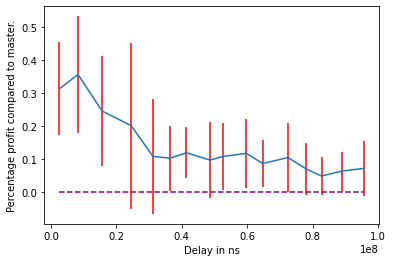

In [72]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
plt.hlines(y=[0], xmin=[temp.DELAY['mean'].min()], xmax=[temp.DELAY['mean'].max()], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()